
- Train a simple K-neighbors classifier for computer vision
- Train neural nets to tell dogs from roads
- Improve your model with convolutional neural networks!
- Use a saliency map to implement explainable AI

In [34]:
#@title Load Packages and creater the CNNClassifier  { display-mode: "form" }
#I put all packages used from first cell to last here
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from collections import Counter
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


def categorical_to_onehot(labels_in):
  labels = []
  for label in labels_in:
    if label == 'dog':
      labels.append(np.array([1, 0]))
    else:
      labels.append(np.array([0, 1]))
  return np.array(labels)

def one_hot_encoding(input):
  output = np.zeros((input.size, input.max()+1))
  output[np.arange(input.size), input] = 1

  return output


def load_data():
  # Run this cell to download our data into a file called 'cifar_data'
  !wget -O cifar_data ##cloud link hidden for privacy

  # now load the data from our cloud computer
  import pickle
  data_dict = pickle.load(open( "cifar_data", "rb" ));

  data   = data_dict['data']
  labels = data_dict['labels']

  return data, labels

def plot_one_image(data, labels, img_idx):
  from google.colab.patches import cv2_imshow
  import cv2
  import matplotlib.pyplot as plt

  my_img   = data[img_idx, :].reshape([32,32,3]).copy()
  my_label = labels[img_idx]
  print(f'label: {my_label}')

  fig, ax = plt.subplots(1,1)
  img = ax.imshow(my_img.astype('uint8'), extent=[-1,1,-1,1])

  x_label_list = [0, 8, 16, 24, 32]
  y_label_list = [0, 8, 16, 24, 32]

  ax.set_xticks([-1, -0.5, 0, 0.5, 1])
  ax.set_yticks([-1, -0.5, 0, 0.5, 1])

  ax.set_xticklabels(x_label_list)
  ax.set_yticklabels(y_label_list)

  fig.show(img)

def logits_to_one_hot_encoding(input):

    output = np.zeros_like(input, dtype=int)
    output[np.arange(len(input)), np.argmax(input, axis=1)] = 1
    return output


class CNNClassifier:

    def __init__(self, num_epochs=30, layers=4, dropout=0.5):
        self.num_epochs = num_epochs
        self.layers = layers
        self.dropout = dropout
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        model.add(Reshape((32, 32, 3)))

        for i in range(self.layers):
          model.add(Conv2D(32, (3, 3), padding='same'))
          model.add(Activation('relu'))

        model.add(Conv2D(32, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(self.dropout))

        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(self.dropout))

        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(Dropout(self.dropout))
        model.add(Dense(2))
        model.add(Activation('softmax'))
        opt = keras.optimizers.legacy.RMSprop(learning_rate=0.0001, decay=1e-6)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

        return model

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, epochs=self.num_epochs, batch_size=10, verbose=2, **kwargs)

    def predict(self, *args, **kwargs):
        predictions = self.model.predict(*args, **kwargs)
        return logits_to_one_hot_encoding(predictions)

    def predict_proba(self, *args, **kwargs):
        predictions = self.model.predict(*args, **kwargs)
        return predictions

    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

    def __getattr__(self, name):
        if name != 'predict' and name != 'predict_proba':
            return getattr(self.model, name)
        else:
            raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")


def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')
    ax.legend(loc = 7)
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')

    plt.show()

# Understanding our data

In [ ]:
data, labels = load_data()

label: dog


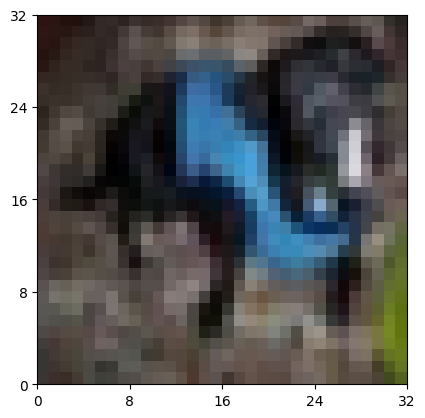

In [4]:
plot_one_image(data, labels, 0)

label: road


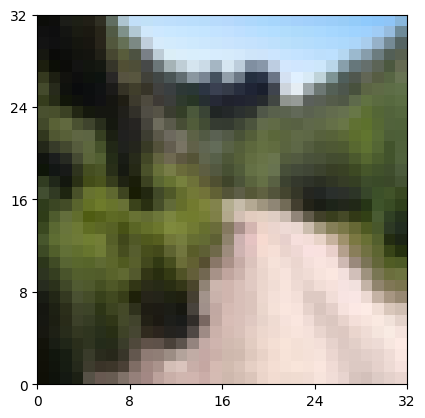

In [5]:
plot_one_image(data, labels, 700)

In [6]:
print(len(data))
print(Counter(labels))

1200
Counter({'dog': 600, 'road': 600})


The dataset is organized such that there are 600 images of dogs and 600 images of roads.

label: dog
label: dog
label: dog
label: dog
label: dog
label: road
label: road
label: road
label: road
label: road


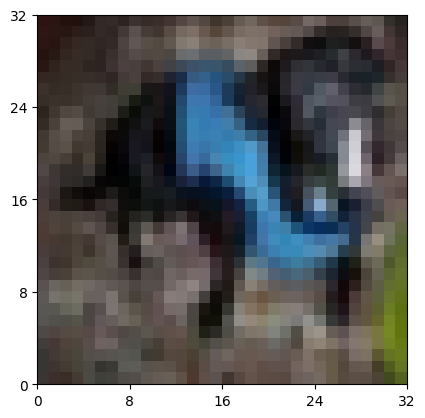

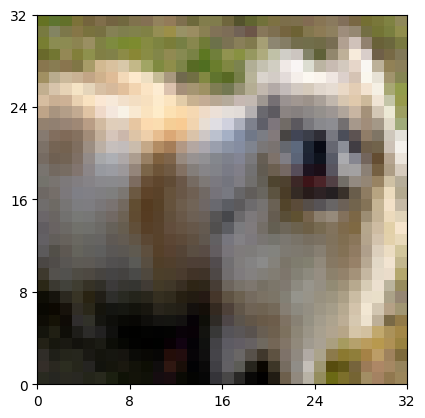

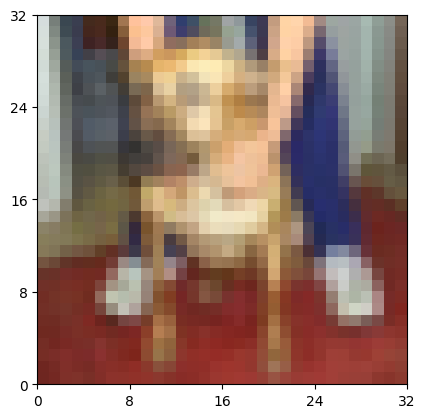

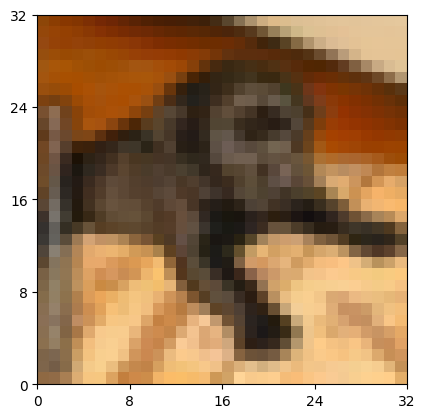

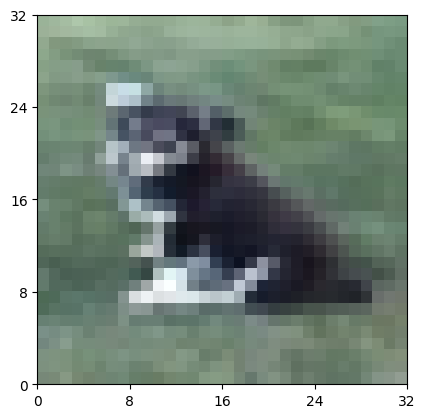

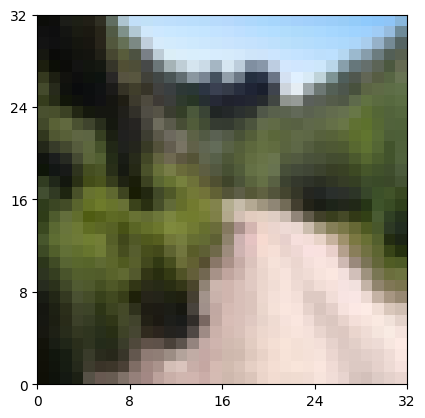

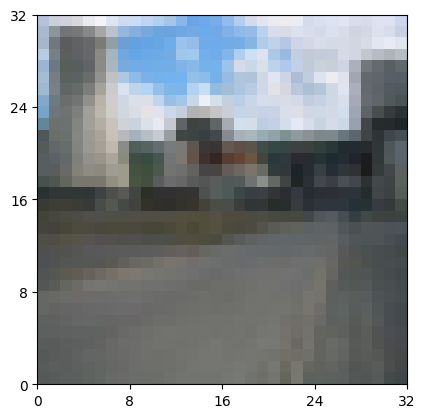

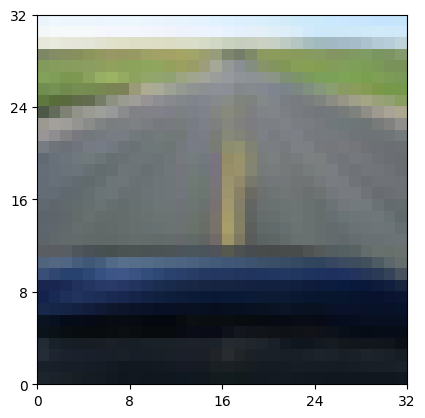

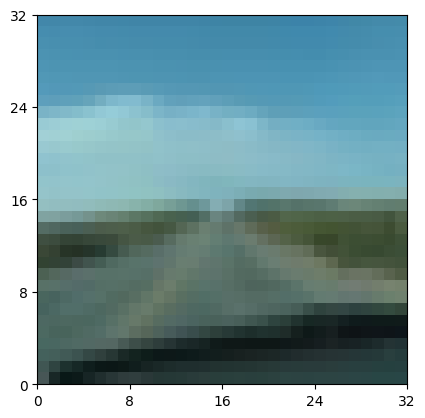

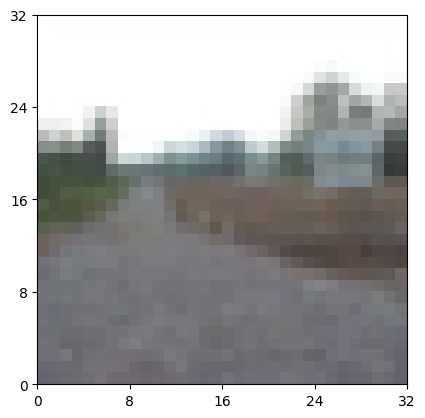

In [7]:
for i in range(5):
  plot_one_image(data, labels, i)

for i in range(700, 705):
  plot_one_image(data, labels, i)

In [8]:
print(data[0], '\n')
print("Length of list:", len(data[0]))

[45 20 19 ... 83 99 31] 

Length of list: 3072


In [9]:
print ('Data shape:', data.shape)
print (data)

Data shape: (1200, 3072)
[[ 45  20  19 ...  83  99  31]
 [101 114  35 ... 155 134  91]
 [213 221 221 ... 139  58  47]
 ...
 [126 174 202 ... 124 128 129]
 [191 232 240 ...  74  93  81]
 [237 248 254 ...  45  56  10]]


##Building a KNN##

In [10]:
#@title KNN { display-mode: "form" }

# Preparing data and create training and test inputs and labels
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, labels, test_size=0.2, random_state=1)

# Initializing our model
knn_model = KNeighborsClassifier(n_neighbors=3)

# Training our model with its training input data and labels
knn_model.fit(X_train, y_train)

# Predict what the classes are based on the testing data
predictions = knn_model.predict(X_test)

# Print the score on the testing data
print("KNN Testing Set Accuracy:")
print(accuracy_score(y_test, predictions)*100)

KNN Testing Set Accuracy:
80.0


##Predicting on images

We can use our trained model to predict whether our car is seeing a `dog` or `road`. Let's try this out - experiment with different images!


label: road
prediction: road


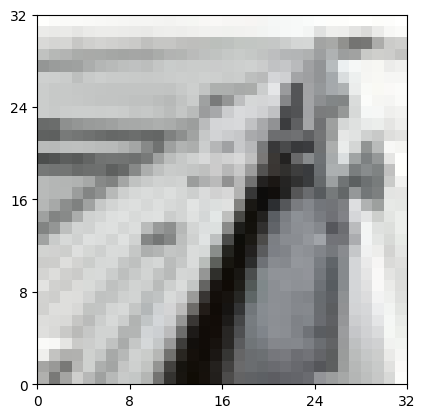

In [11]:
image_id = 100

plot_one_image(X_test, y_test, image_id)

print('prediction:', knn_model.predict([X_test[image_id]])[0])

In [12]:
# Initialize variables to keep track of the best k and highest accuracy
best_k = None
highest_accuracy = 0

# List of k values to test
k_values = [1, 3, 5, 10, 20, 30, 2, 3, 4, 5, 6, 7, 8]

for k in k_values:
    # Define and fit the KNN model
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)

    # Make predictions and calculate accuracy
    predictions = knn_model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions) * 100

    # Print accuracy for current k
    print(f"KNN testing set accuracy for {k} neighbors: {accuracy:.2f}%")

    # Update best k and highest accuracy if current accuracy is higher
    if accuracy > highest_accuracy:
        highest_accuracy = accuracy
        best_k = k

# Print the most effective k value and its accuracy
print(f"\nThe most effective k value is {best_k} with an accuracy of {highest_accuracy:.2f}%")

KNN testing set accuracy for 1 neighbors: 80.00%
KNN testing set accuracy for 3 neighbors: 80.00%
KNN testing set accuracy for 5 neighbors: 79.17%
KNN testing set accuracy for 10 neighbors: 82.92%
KNN testing set accuracy for 20 neighbors: 82.50%
KNN testing set accuracy for 30 neighbors: 81.67%
KNN testing set accuracy for 2 neighbors: 89.17%
KNN testing set accuracy for 3 neighbors: 80.00%
KNN testing set accuracy for 4 neighbors: 86.67%
KNN testing set accuracy for 5 neighbors: 79.17%
KNN testing set accuracy for 6 neighbors: 83.75%
KNN testing set accuracy for 7 neighbors: 80.00%
KNN testing set accuracy for 8 neighbors: 83.75%

The most effective k value is 2 with an accuracy of 89.17%


TRUE POSITIVES
label: dog
label: dog
label: dog
label: dog
FALSE POSITIVES
label: road
label: road
TRUE NEGATIVES
label: road
label: road
label: road
label: road
FALSE NEGATIVES
label: dog
label: dog
label: dog
label: dog


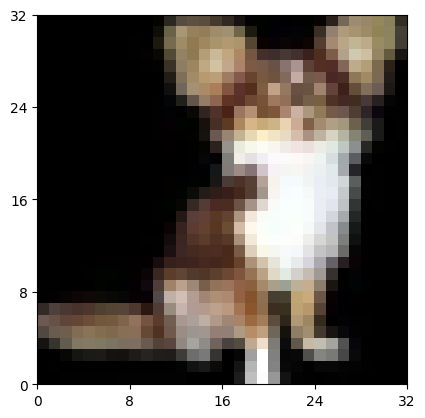

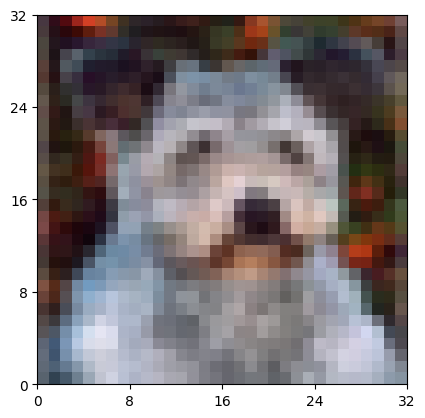

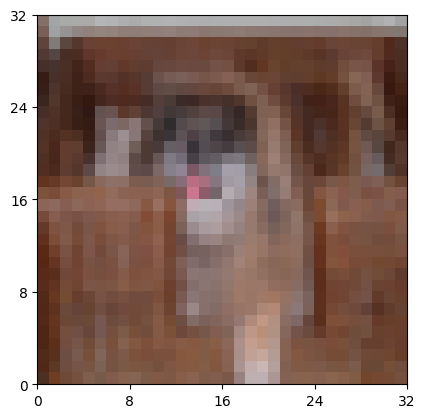

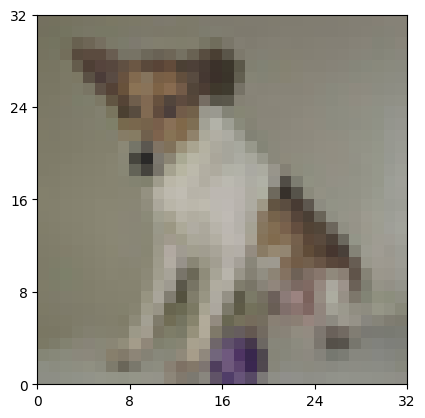

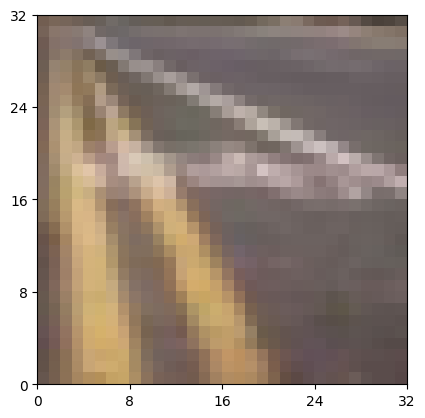

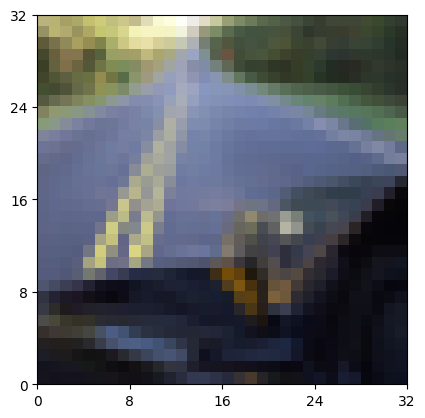

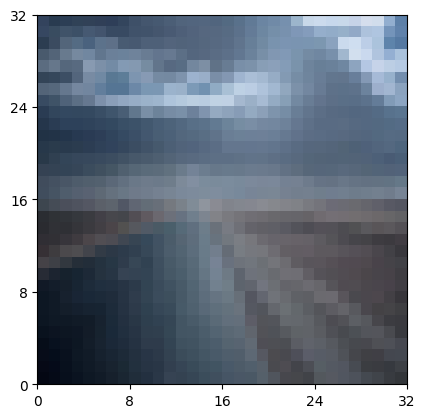

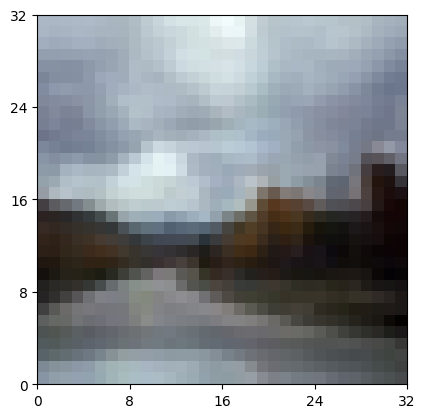

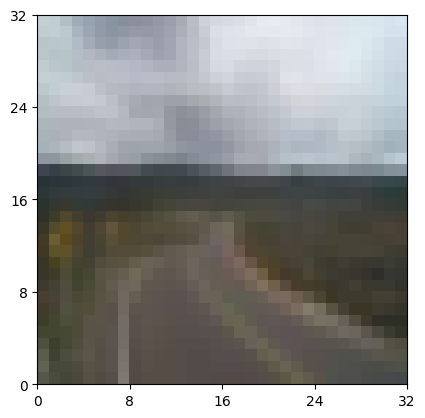

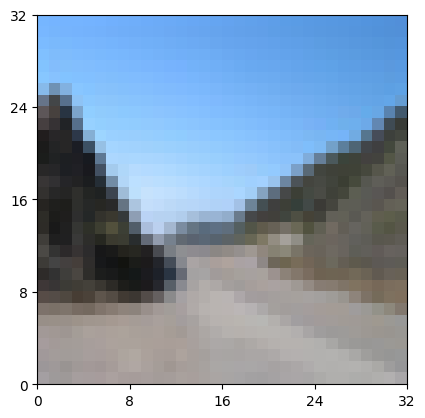

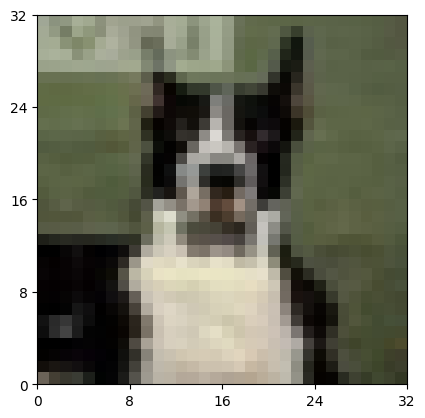

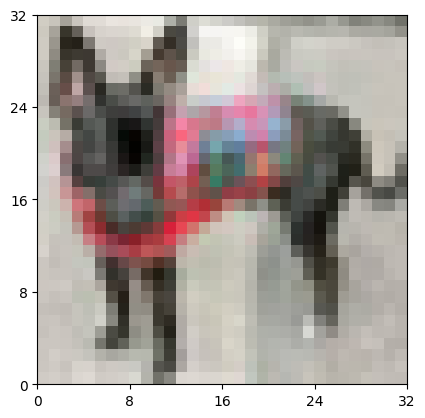

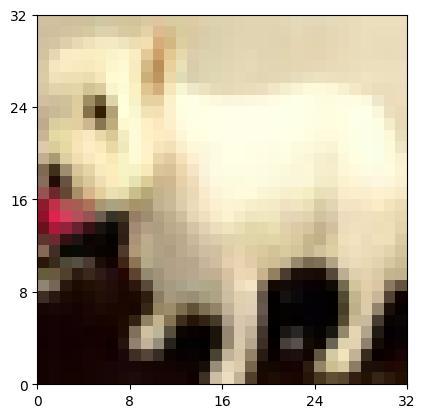

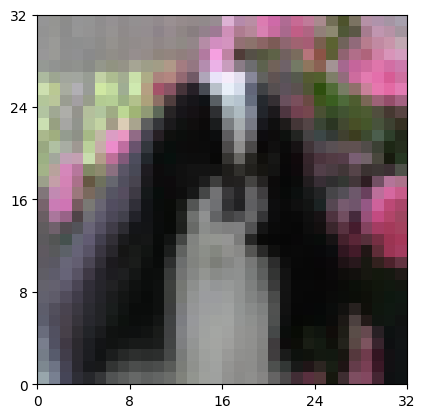

In [13]:
#@title Matrix of Errors

# True Positives
print ("TRUE POSITIVES")
tp_count = 0
i = 0
while tp_count < 4 and i < len(X_test):
  prediction = knn_model.predict([X_test[i]])[0]
  if prediction == y_test[i] and prediction == 'dog':
    plot_one_image(X_test, y_test, i)
    tp_count += 1
  i += 1

# False Positives
print ("FALSE POSITIVES")
fp_count = 0
i = 0
while fp_count < 4 and i < len(X_test):
  prediction = knn_model.predict([X_test[i]])[0]
  if prediction != y_test[i] and prediction == 'dog':
    plot_one_image(X_test, y_test, i)
    fp_count += 1
  i += 1

# True Negatives
print ("TRUE NEGATIVES")
tn_count = 0
i = 0
while tn_count < 4 and i < len(X_test):
  prediction = knn_model.predict([X_test[i]])[0]
  if prediction == y_test[i] and prediction == 'road':
    plot_one_image(X_test, y_test, i)
    tn_count += 1
  i += 1


# False Negatives
print ("FALSE NEGATIVES")
fn_count = 0
i = 0
while fn_count < 4 and i < len(X_test):
  prediction = knn_model.predict([X_test[i]])[0]
  if prediction != y_test[i] and prediction == 'road':
    plot_one_image(X_test, y_test, i)
    fn_count += 1
  i += 1



Generally the false classifications are images that are much closer to the subject. One reason the model may make mistakes is that these images are on the boundaries of their clusters.

###3 Layer MLP, with comments

In [15]:
from IPython.display import display, Markdown

display(Markdown("# 3-Layer MLP with too many comments"))

# Split the data into training and testing sets
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the MLP model with potential hyperparameters
nnet = MLPClassifier(
    hidden_layer_sizes=(10, 5, 4),  # Number of neurons in each hidden layer
    activation='relu',              # Activation function
    solver='adam',                 # Optimization algorithm
    learning_rate='adaptive',       # Learning rate schedule
    max_iter=10000,                 # Maximum number of iterations
    random_state=1,                 # Seed for random number generator
    early_stopping=True,            # Stop training when validation score is not improving
    validation_fraction=0.1,        # Proportion of training data to set aside for validation
    n_iter_no_change=10             # Number of iterations with no improvement to wait before stopping
)

# Fit the model
nnet.fit(X_train_scaled, y_train)

# Make predictions
predictions = nnet.predict(X_test_scaled)

# Print accuracy
print("MLP Testing Accuracy:")
print(f"{accuracy_score(y_test, predictions) * 100:.2f}%")

# 3-Layer MLP with too many comments

MLP Testing Accuracy:
86.67%


In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np

# Example dataset (replace with your actual data)
# X_train, X_test, y_train, y_test should be defined here

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Train a 1-layer, 10-neuron network
print("Training 1-Layer, 10-Neuron Network")
nnet_1_layer = MLPClassifier(
    hidden_layer_sizes=(10,),  # Single hidden layer with 10 neurons
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    max_iter=1000,
    random_state=1
)
nnet_1_layer.fit(X_train_scaled, y_train)
predictions_1_layer = nnet_1_layer.predict(X_test_scaled)
print(f"1-Layer, 10-Neuron Network Accuracy: {accuracy_score(y_test, predictions_1_layer) * 100:.2f}%\n")

# 2. Experiment with Different Configurations
configs = [
    {'hidden_layer_sizes': (10,), 'max_iter': 1000},    # 1 layer, 10 neurons
    {'hidden_layer_sizes': (20,), 'max_iter': 1000},    # 1 layer, 20 neurons
    {'hidden_layer_sizes': (10, 10), 'max_iter': 1000}, # 2 layers, 10 neurons each
    {'hidden_layer_sizes': (20, 10), 'max_iter': 1000}, # 2 layers, 20 and 10 neurons
    {'hidden_layer_sizes': (10, 10, 10), 'max_iter': 1000}, # 3 layers, 10 neurons each
    {'hidden_layer_sizes': (20, 15, 10), 'max_iter': 2000}, # 3 layers with varying neurons
]

print("Experimenting with Different Configurations")
for config in configs:
    nnet = MLPClassifier(
        hidden_layer_sizes=config['hidden_layer_sizes'],
        activation='relu',
        solver='adam',
        learning_rate='adaptive',
        max_iter=config['max_iter'],
        random_state=1
    )
    nnet.fit(X_train_scaled, y_train)
    predictions = nnet.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, predictions) * 100
    print(f"Network with hidden layers {config['hidden_layer_sizes']} and {config['max_iter']} iterations Accuracy: {accuracy:.2f}%\n")

# 3. Increase or Decrease the Number of Iterations
iteration_configs = [
    {'hidden_layer_sizes': (10,), 'max_iter': 100},    # Fewer iterations
    {'hidden_layer_sizes': (10,), 'max_iter': 1000},   # More iterations
    {'hidden_layer_sizes': (10,), 'max_iter': 5000},   # Even more iterations
]

print("Increasing/Decreasing Number of Iterations")
for config in iteration_configs:
    nnet = MLPClassifier(
        hidden_layer_sizes=config['hidden_layer_sizes'],
        activation='relu',
        solver='adam',
        learning_rate='adaptive',
        max_iter=config['max_iter'],
        random_state=1
    )
    nnet.fit(X_train_scaled, y_train)
    predictions = nnet.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, predictions) * 100
    print(f"Network with {config['max_iter']} iterations Accuracy: {accuracy:.2f}%\n")


Training 1-Layer, 10-Neuron Network
1-Layer, 10-Neuron Network Accuracy: 91.25%

Experimenting with Different Configurations
Network with hidden layers (10,) and 1000 iterations Accuracy: 91.25%

Network with hidden layers (20,) and 1000 iterations Accuracy: 86.67%

Network with hidden layers (10, 10) and 1000 iterations Accuracy: 88.75%

Network with hidden layers (20, 10) and 1000 iterations Accuracy: 88.75%

Network with hidden layers (10, 10, 10) and 1000 iterations Accuracy: 86.25%

Network with hidden layers (20, 15, 10) and 2000 iterations Accuracy: 91.25%

Increasing/Decreasing Number of Iterations
Network with 100 iterations Accuracy: 91.25%

Network with 1000 iterations Accuracy: 91.25%

Network with 5000 iterations Accuracy: 91.25%



In [17]:
#@title Loop for Automation
for layers in [(1,1), (3,3), (5,5), (8,6), (10,10,10), (10,10,5)]:

  print('Layer params are ...')
  print(layers)
  nnet = MLPClassifier(hidden_layer_sizes=layers, random_state=1, max_iter=100)

  nnet.fit(X_train, y_train)

  predictions = nnet.predict(X_test)

  print("MLP Testing Accuracy:")
  print(accuracy_score(y_test, predictions) * 100)
  print()

Layer params are ...
(1, 1)
MLP Testing Accuracy:
47.083333333333336

Layer params are ...
(3, 3)
MLP Testing Accuracy:
47.083333333333336

Layer params are ...
(5, 5)
MLP Testing Accuracy:
52.916666666666664

Layer params are ...
(8, 6)
MLP Testing Accuracy:
44.166666666666664

Layer params are ...
(10, 10, 10)
MLP Testing Accuracy:
52.916666666666664

Layer params are ...
(10, 10, 5)
MLP Testing Accuracy:
90.41666666666667



In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Example dataset (replace with your actual data)
# X_train, X_test, y_train, y_test should be defined here

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to train and evaluate the model with given configuration
def evaluate_model(hidden_layer_sizes, max_iter):
    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation='relu',
        solver='adam',
        learning_rate='adaptive',
        max_iter=max_iter,
        random_state=1
    )
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, predictions) * 100
    return accuracy

# Initialize parameters for auto-tuning
target_accuracy = 93
iterations = 0
max_iterations = 10  # Limit to prevent infinite loops

# Initial configuration
current_config = [10]  # Start with a single layer of 10 neurons
max_layers = 3  # Maximum number of layers
max_neurons = 50  # Maximum number of neurons per layer
step_size = 5  # Increment step for neurons

best_accuracy = 0
best_config = None

while best_accuracy < target_accuracy and iterations < max_iterations:
    current_accuracy = evaluate_model(tuple(current_config), max_iter=1000)
    print(f"Testing config: {current_config} with accuracy: {current_accuracy:.2f}%")

    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_config = current_config.copy()

    if current_accuracy >= target_accuracy:
        break  # Exit loop if desired accuracy is achieved

    # Increase complexity by adding neurons
    improved = False
    for i in range(len(current_config)):
        if current_config[i] + step_size <= max_neurons:
            current_config[i] += step_size
            improved = True
            break

    # If we can't add neurons to existing layers, add a new layer
    if not improved and len(current_config) < max_layers:
        current_config.append(step_size)
        improved = True

    # If we can't improve by adding neurons or layers, reduce neurons and retry
    if not improved:
        for i in range(len(current_config)):
            if current_config[i] - step_size > 0:
                current_config[i] -= step_size
                break

    iterations += 1

# Print final results
if best_accuracy >= target_accuracy:
    print(f"Achieved target accuracy of {target_accuracy}% with configuration: {best_config}")
else:
    print(f"Failed to achieve target accuracy after {iterations} iterations. Best accuracy: {best_accuracy:.2f}% with configuration: {best_config}")


Testing config: [10] with accuracy: 91.25%
Testing config: [15] with accuracy: 88.33%
Testing config: [20] with accuracy: 86.67%
Testing config: [25] with accuracy: 89.58%
Testing config: [30] with accuracy: 89.58%
Testing config: [35] with accuracy: 90.42%
Testing config: [40] with accuracy: 90.00%
Testing config: [45] with accuracy: 87.50%
Testing config: [50] with accuracy: 88.33%
Testing config: [50, 5] with accuracy: 90.42%
Testing config: [50, 10] with accuracy: 87.50%
Testing config: [50, 15] with accuracy: 90.00%
Testing config: [50, 20] with accuracy: 91.25%
Testing config: [50, 25] with accuracy: 89.58%
Testing config: [50, 30] with accuracy: 88.33%
Testing config: [50, 35] with accuracy: 89.17%
Testing config: [50, 40] with accuracy: 89.58%
Testing config: [50, 45] with accuracy: 88.33%
Testing config: [50, 50] with accuracy: 89.58%
Testing config: [50, 50, 5] with accuracy: 90.00%
Testing config: [50, 50, 10] with accuracy: 89.58%
Testing config: [50, 50, 15] with accuracy:

# Models for Vision: Convolutional Neural Networks


In [21]:
#@title Convert your string labels to one-hot encodings using categorical_to_onehot(data), then train and test your CNN with the modified data, saving the variables as y_train_onehot and y_test_onehot. We have already converted X_train and X_test to decimal numbers.{ display-mode: "form" }
# convert our data to floats for our CNN
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# convert our labels to one-hot vectors!
y_test_onehot = categorical_to_onehot(y_test)
y_train_onehot = categorical_to_onehot(y_train)

# Create and train our CNN model
cnn = CNNClassifier(num_epochs=40)

cnn.fit(X_train, y_train_onehot)

# Predict what the classes are based on the testing data
predictions = cnn.predict(X_test)

# Print the score on the testing data
print("CNN Testing Set Score:")
print(accuracy_score(y_test_onehot, predictions)*100)

Epoch 1/40
96/96 - 6s - loss: 1.8703 - accuracy: 0.6198 - 6s/epoch - 67ms/step
Epoch 2/40
96/96 - 1s - loss: 0.5679 - accuracy: 0.8021 - 707ms/epoch - 7ms/step
Epoch 3/40
96/96 - 1s - loss: 0.4038 - accuracy: 0.8479 - 659ms/epoch - 7ms/step
Epoch 4/40
96/96 - 1s - loss: 0.2997 - accuracy: 0.8771 - 682ms/epoch - 7ms/step
Epoch 5/40
96/96 - 1s - loss: 0.2684 - accuracy: 0.9031 - 684ms/epoch - 7ms/step
Epoch 6/40
96/96 - 1s - loss: 0.2385 - accuracy: 0.9031 - 596ms/epoch - 6ms/step
Epoch 7/40
96/96 - 1s - loss: 0.2300 - accuracy: 0.9135 - 625ms/epoch - 7ms/step
Epoch 8/40
96/96 - 1s - loss: 0.2081 - accuracy: 0.9271 - 764ms/epoch - 8ms/step
Epoch 9/40
96/96 - 1s - loss: 0.1912 - accuracy: 0.9292 - 773ms/epoch - 8ms/step
Epoch 10/40
96/96 - 1s - loss: 0.1692 - accuracy: 0.9365 - 696ms/epoch - 7ms/step
Epoch 11/40
96/96 - 1s - loss: 0.1506 - accuracy: 0.9458 - 838ms/epoch - 9ms/step
Epoch 12/40
96/96 - 1s - loss: 0.1554 - accuracy: 0.9438 - 1s/epoch - 11ms/step
Epoch 13/40
96/96 - 1s - loss

Epoch 1/20
96/96 - 2s - loss: 3.4466 - accuracy: 0.5792 - val_loss: 0.4141 - val_accuracy: 0.8333 - 2s/epoch - 20ms/step
Epoch 2/20
96/96 - 0s - loss: 0.6289 - accuracy: 0.7677 - val_loss: 0.3569 - val_accuracy: 0.8083 - 470ms/epoch - 5ms/step
Epoch 3/20
96/96 - 0s - loss: 0.3830 - accuracy: 0.8427 - val_loss: 0.3520 - val_accuracy: 0.8375 - 459ms/epoch - 5ms/step
Epoch 4/20
96/96 - 0s - loss: 0.3421 - accuracy: 0.8573 - val_loss: 0.2607 - val_accuracy: 0.8875 - 457ms/epoch - 5ms/step
Epoch 5/20
96/96 - 0s - loss: 0.2470 - accuracy: 0.8990 - val_loss: 0.1960 - val_accuracy: 0.9333 - 481ms/epoch - 5ms/step
Epoch 6/20
96/96 - 0s - loss: 0.2288 - accuracy: 0.9104 - val_loss: 0.2133 - val_accuracy: 0.9208 - 454ms/epoch - 5ms/step
Epoch 7/20
96/96 - 0s - loss: 0.1845 - accuracy: 0.9229 - val_loss: 0.1462 - val_accuracy: 0.9542 - 470ms/epoch - 5ms/step
Epoch 8/20
96/96 - 0s - loss: 0.2060 - accuracy: 0.9292 - val_loss: 0.1419 - val_accuracy: 0.9667 - 456ms/epoch - 5ms/step
Epoch 9/20
96/96 -

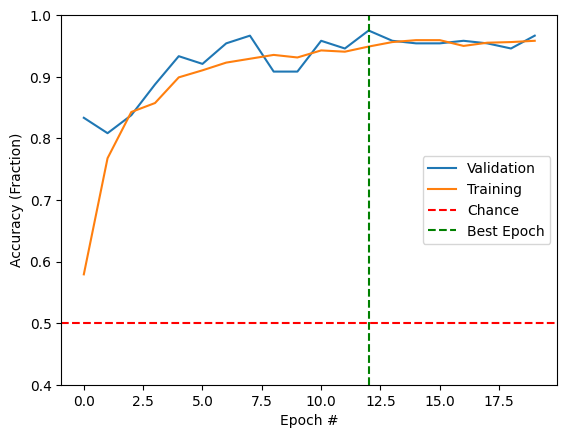

In [22]:
#@title Train vs Test with CNN { display-mode: "form" }

cnn = CNNClassifier(num_epochs=20)

history = cnn.fit(X_train, y_train_onehot, validation_data=(X_test, y_test_onehot))

plot_acc(history)

###**Saliency Maps**

It's very difficult to explain exactly why a neural network makes the decisions it does. This makes it difficult to trust them as they can't explain why they do what they do. If you are a banker and you tell someone they have been rejected for a loan, and they ask why, showing them a bunch of complex NeuralNet weights could lead to your company getting sued. That's why we can use saliency maps!





(3072,)
[120. 127.  39. ... 117. 116.  49.]


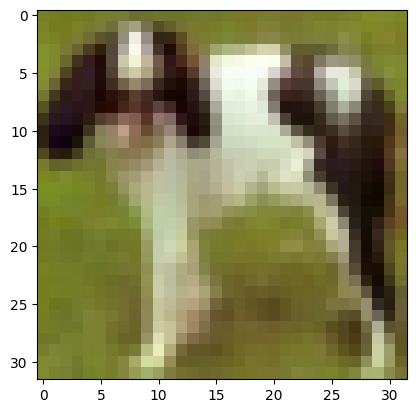

Classification:
1/1 [==============================] - 0s 28ms/step
Predicted: Dog


In [33]:
image_index = 120
input_image = X_test[image_index]
print(input_image.shape)
print(input_image)

plt.imshow(input_image.reshape(32,32,3).astype(int))
plt.show()

print('Classification:')
if(np.argmax(cnn.predict(np.array([input_image]))) == 0):
  print("Predicted: Dog")
else:
  print("Predicted: Road")
# 0 means dog, 1 means road

#How did the model get here? We don't know. Well we do, but we cannot explain the math in a logical way

### Here are the weights (ugly to look at, but they mean something)

In [30]:
for layer_weights in history.model.weights:
  print (layer_weights)

  ##If you run it, it will take up more than half of this notebook, it's a lot of weights for a CNN.
  ##That does show us though why I should use Saliency Maps

<tf.Variable 'conv2d_7/kernel:0' shape=(3, 3, 3, 32) dtype=float32, numpy=
array([[[[-0.05394526,  0.03169658, -0.09242639, -0.0178557 ,
           0.0380823 , -0.11165125,  0.03233517, -0.06313264,
           0.03285256, -0.1364125 , -0.11836632, -0.07245117,
           0.01135206, -0.05541664, -0.12761989,  0.01090258,
           0.09611257,  0.02544519, -0.03664587, -0.11190249,
          -0.08535998, -0.06590591,  0.0038037 ,  0.02822189,
           0.08333056,  0.05942754, -0.13734068, -0.05012191,
           0.11877178,  0.09932069,  0.09889022, -0.10399271],
         [-0.05656281,  0.05030968,  0.08188072,  0.13526629,
           0.10835651, -0.06591372, -0.09018643,  0.13450845,
          -0.11016028,  0.10561385, -0.01896161,  0.06270726,
           0.02148127, -0.02286873,  0.09000179, -0.02158315,
          -0.05991498, -0.05172132, -0.08050673,  0.11030963,
           0.05197545, -0.02534527, -0.12902065,  0.00700533,
          -0.11041507, -0.02945425, -0.0418497 , -0.1335

### Builid Saliency Maps, because explaining all the weights is not possible

We're going to use the raw predicted probabilities, rather than the final classification.

In [25]:
pred = cnn.predict_proba(np.array([input_image]))
print(pred)
dog_prob = pred[0][0]

print('Probability of dog:')
print(dog_prob)

1/1 [==============================] - 0s 28ms/step
[[0.98498034 0.01501964]]
Probability of dog:
0.98498034


Now, we need to calculate the saliency for each pixel (really, each RGB value). The core idea is that a pixel's saliency is the average value of

 $D = \left|\frac{\Delta probability}{\Delta pixel}\right|$

 where $\Delta$ is the amount of change.


In [31]:
#@title Saliency Calculator that runs in my lifetime
saliencies = []
all_changed_pixels = []
pixel_differences = []
for index, pixel in enumerate(input_image):

  changed_input = input_image.copy() #make sure not to change the original input_image, that gets you in trouble


  D_list = []
  changed_versions_of_pixel = []

  for pixel_change in [-50, -30, -10, 10, 30, 50]:
    changed_pixel = pixel + pixel_change

    if 0 <= changed_pixel <= 255:
      changed_versions_of_pixel.append(changed_pixel)
      pixel_differences.append(pixel- changed_pixel)

  all_changed_pixels.append(changed_versions_of_pixel)


changed_images = []

for j in range(len(changed_input)):
    for i in range(len(all_changed_pixels[j])):
      changed_input[j]= all_changed_pixels[j][i]
      changed_images.append(changed_input)
      changed_input = input_image.copy()

a = cnn.predict_proba(np.array([input_image]))
b = cnn.predict_proba(np.array(changed_images))

a = np.log(a)
b = np.log(b)

dog_prob = a[0][0]
new_b = []
for i in b:
  new_b.append(abs(i[0]) + abs(i[1]))
new_b = np.array(new_b)
probability_changes = new_b - dog_prob
d_total = abs(probability_changes/pixel_differences)



start = 0
end = 0
for i in all_changed_pixels:
  end += len(i)
  saliency = (np.mean(d_total[start:end]))
  start = end
  saliencies.append(saliency)
print("Hi")
print("Non-Normalized Saliencies: \n", saliencies)


534/534 [==============================] - 1s 3ms/step
Hi
Non-Normalized Saliencies: 
 [0.21610902733272974, 0.21610480255550812, 0.24240363311767582, 0.21605962488386365, 0.21615537219577363, 0.2424739933013916, 0.2162075604332818, 0.21603009859720865, 0.24252252960205078, 0.2161139133241441, 0.21619916968875463, 0.24257272148132322, 0.21617321120368108, 0.2161274364259508, 0.2426169001261393, 0.21612282064225938, 0.21609787782033285, 0.2424340909322103, 0.2161924886703491, 0.2162562492158678, 0.24240644391377772, 0.21605996396806504, 0.21612100336286755, 0.21614563941955564, 0.21599070654975042, 0.21597035884857177, 0.24239095242818198, 0.2159535725911458, 0.21599725670284695, 0.24236513710021973, 0.2159644720289442, 0.21588847266303168, 0.24218058395385741, 0.21610433048672148, 0.21586081663767495, 0.24235199673970537, 0.2158581240971883, 0.21582235866122776, 0.24221472803751629, 0.21587569183773467, 0.21617736021677655, 0.24262193044026695, 0.21596439308590357, 0.2161024008856879, 

You'll notice that your saliencies are probably very small values, since each individual pixel has a small effect on the output.
Here are the current min and max:

In [27]:
sal_array = np.array(saliencies)
print (sal_array.min(), sal_array.max())
print (sal_array.shape)

0.2112656741672092 0.26941564162572224
(3072,)


In [28]:
#@title Making sense of the numbers
print (sal_array.min(), sal_array.max())
sal_array = (sal_array - sal_array.min()) / (sal_array.max() - sal_array.min())
print (sal_array.min(), sal_array.max())
sal_array.shape

0.2112656741672092 0.26941564162572224
0.0 1.0


(3072,)

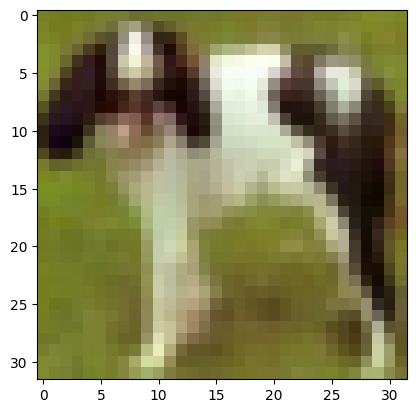

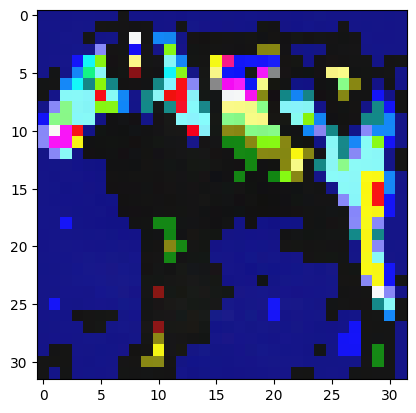

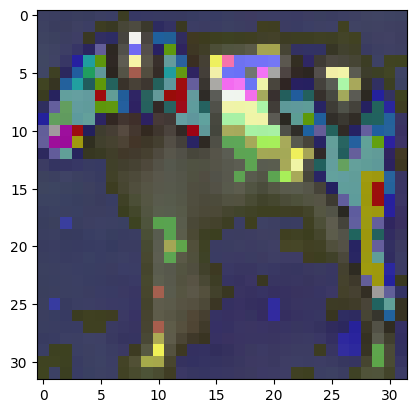

In [29]:
#Plot our original image
plt.imshow(input_image.reshape(32,32,3).astype(int))
plt.show()

plt.imshow(sal_array.reshape(32,32,3))
plt.show()

#Plot our saliency map superimposed on the image
plt.imshow(input_image.reshape(32,32,3).astype(int))
plt.imshow(sal_array.reshape(32,32,3),alpha=0.6)
plt.show()